## Библиотеки

In [34]:
import numpy as np
import matplotlib.pyplot as plt

## Функции

In [2]:
def fill_C(): # Заполнить сетку ненулевыми лямбдами
    C11 = 12.98344389516936
    C12 = 2.76656283641825
    C16 = 5.00630996992227
    C22 = 79.21121100901908
    C26 = 4.88188079023485
    C66 = 13.05325089362048
    C = np.array([(C11, C12, C16),
                  (C12, C22, C26),
                  (C16, C26, C66)])
    C *= 1e9 # Гигапаскали - 10^9
    return C
            
def Omega(q, Omega):
    return Omega @ q

def Omega_inv(w, Omega_inv):
    q = Omega_inv @ w
    return (q[0], q[1], q[2], q[3], q[4])

def source(t):
    return A * np.sin(2 * np.pi * f * t) # F = sin(2πft)

def makeStep(wp, w, wn, c):
    if c > 0:
        return w - c * dt / h * (w - wp) # Схема для положительной лямбды
    elif c < 0:
        return w + c * dt / h * (wn - w) # Схема для отрицательной лямбды
    else:
        return w # Нулевая волна

## Переменные

In [3]:
L = 4000 # Размер области (м)
M = 100 # Количество узлов вдоль оси (L/M = 40 м)
C = fill_C() # (Па)
print("Matrix C =", '\n', C)
rho = 2200 # Плотность среды (кг/м^3)
h = L / M # Шаг по координате (м)
data_current = np.zeros((M, M), dtype=[('vx', np.float64), ('vy', np.float64), # По умолчанию нулевые элекменты
                                  ('sxx', np.float64), ('syy', np.float64), ('sxy', np.float64)])
data_next = np.zeros((M, M), dtype=[('vx', np.float64), ('vy', np.float64),
                                  ('sxx', np.float64), ('syy', np.float64), ('sxy', np.float64)])

Matrix C = 
 [[1.29834439e+10 2.76656284e+09 5.00630997e+09]
 [2.76656284e+09 7.92112110e+10 4.88188079e+09]
 [5.00630997e+09 4.88188079e+09 1.30532509e+10]]


## Численные вычисления матриц

In [4]:
import scipy.linalg as sci

In [5]:
Ax = np.array([[0,         0,         -1/rho, 0, 0     ],
               [0,         0,         0,      0, -1/rho],
               [-C[0][0], -C[0][2]/2, 0,      0, 0     ],
               [-C[0][1], -C[1][2]/2, 0,      0, 0     ],
               [-C[0][2], -C[2][2]/2, 0,      0, 0     ]])

Ay = np.array([[0,           0,       0, 0,      -1/rho],
               [0,           0,       0, -1/rho, 0     ],
               [-C[0][2]/2, -C[0][1], 0, 0,      0     ],
               [-C[1][2]/2, -C[1][1], 0, 0,      0     ],
               [-C[2][2]/2, -C[1][2], 0, 0,      0,    ]])
eigo_x = sci.eig(Ax) #Функция считает СВ и СЗ и сохраняет их в кортеж. Векторы в столбцы.
eigo_y = sci.eig(Ay)
Omegax_inv = eigo_x[1]
Omegay_inv = eigo_y[1]
Lamx = np.diag(eigo_x[0])
Lamx = Lamx.real #Берём действительную часть, мы же знаем, что у матрицы СЗ действительные
Lamy = np.diag(eigo_y[0])
Lamy = Lamy.real
Omegax = np.linalg.inv(Omegax_inv)
Omegay = np.linalg.inv(Omegay_inv)
print(Lamx)
#print(Lamx, '\n', Omegax_inv, '\n', Omegax)
#print(Ax, '\n', Omegax_inv @ Lamx @ Omegax)
#print(np.linalg.inv(Omegax), '\n')
print('\n')
print(Lamy)
#print(Lamy, '\n', Omegay_inv, '\n', Omegay)
#print(Ay, '\n', Omegay_inv @ Lamy @ Omegay)
#print(np.linalg.inv(Omegay))

[[    0.             0.             0.             0.
      0.        ]
 [    0.         -2571.35341127     0.             0.
      0.        ]
 [    0.             0.         -1502.11683022     0.
      0.        ]
 [    0.             0.             0.          1502.11683022
      0.        ]
 [    0.             0.             0.             0.
   2571.35341127]]


[[    0.             0.             0.             0.
      0.        ]
 [    0.          6006.61715889     0.             0.
      0.        ]
 [    0.             0.         -6006.61715889     0.
      0.        ]
 [    0.             0.             0.         -1700.67461615
      0.        ]
 [    0.             0.             0.             0.
   1700.67461615]]


Оставлю, как историческое назидание невежству, что перемножение матриц в numpy производится с помощью "@", а то, что производится звёздочкой - поэлементное умножение

## Начальные условия

In [69]:
for j in range(M):
    for i in range(M):
        #if (i > M / 3.0) and (i < 2.0 * M / 3.0) and (j > M / 3.0) and (j < 2.0 * M / 3.0):
        if (M // 2 - i) ** 2 + (M // 2 - j) ** 2 < 25.0:
            data_current[i, j]['sxx'] = 1.0
            data_current[i, j]['syy'] = 1.0
            data_current[i, j]['sxy'] = 0.0
            data_current[i, j]['vx']  = 0.0
            data_current[i, j]['vy']  = 0.0
        else:
            data_current[i, j] = (0, 0, 0, 0, 0)
#data_current[0, 0]['sxx'] = 5
data_start = data_current.copy()
#print(data_current['sxx'])

## Расчёт

In [70]:
(c1x, c2x, c3x, c4x, c5x) = eigo_x[0].real
print(eigo_x[0].real)
(c1y, c2y, c3y, c4y, c5y) = eigo_y[0].real
print(eigo_y[0].real)
#T = 1/f
T = 1.0
#T = 0.2 * L / max(c1x, c2x, c1y, c2y) # 1 полный оборот начального возмущения
dt = 5e-3
#dt = 0.4 * h / max(c1x, c2x, c1y, c2y) # коэффициент должен быть меньше единицы
#print(T / dt)

for k in range(int(T / dt)): # w1 for 0, w2, w3 for c-, w4, w5 for c+
    # Шаг по X
    for j in range(M):
        for i in range(M):
            if i == 0:       # Граница слева
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_current[j, i]), Omegax)
                (w1n, w2n, w3n, w4n, w5n) = Omega(list(data_current[j, i + 1]), Omegax)
                (w1p, w2p, w3p, w4p, w5p) = (w1 , w2 , w3 , w4 , w5 )
                w1_new = makeStep(w1p, w1, w1n, c1x)
                w2_new = makeStep(w2p, w2, w2n, c2x)
                w3_new = makeStep(w3p, w3, w3n, c3x)
                w4_new = makeStep(w4p, w4, w4n, c4x)
                w5_new = makeStep(w5p, w5, w5n, c5x)
                data_next[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegax_inv)
            elif i == M - 1: # Граница справа
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_current[j, i]), Omegax)
                (w1n, w2n, w3n, w4n, w5n) = (w1 , w2 , w3 , w4 , w5 )
                (w1p, w2p, w3p, w4p, w5p) = Omega(list(data_current[j, i - 1]), Omegax)
                w1_new = makeStep(w1p, w1, w1n, c1x)
                w2_new = makeStep(w2p, w2, w2n, c2x)
                w3_new = makeStep(w3p, w3, w3n, c3x)
                w4_new = makeStep(w4p, w4, w4n, c4x)
                w5_new = makeStep(w5p, w5, w5n, c5x)
                data_next[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegax_inv)            
            else:            # Не граница
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_current[j, i]), Omegax)
                (w1n, w2n, w3n, w4n, w5n) = Omega(list(data_current[j, i + 1]), Omegax)
                (w1p, w2p, w3p, w4p, w5p) = Omega(list(data_current[j, i - 1]), Omegax)
                w1_new = makeStep(w1p, w1, w1n, c1x)
                w2_new = makeStep(w2p, w2, w2n, c2x)
                w3_new = makeStep(w3p, w3, w3n, c3x)
                w4_new = makeStep(w4p, w4, w4n, c4x)
                w5_new = makeStep(w5p, w5, w5n, c5x)
                data_next[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegax_inv)
    # Шаг по Y
    for i in range(M):
        for j in range(M):
            if j == 0:       # Граница слева
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_next[j, i]), Omegay)
                (w1n, w2n, w3n, w4n, w5n) = Omega(list(data_next[j + 1, i]), Omegay)
                (w1p, w2p, w3p, w4p, w5p) = (w1 , w2 , w3 , w4 , w5 )
                w1_new = makeStep(w1p, w1, w1n, c1y)
                w2_new = makeStep(w2p, w2, w2n, c2y)
                w3_new = makeStep(w3p, w3, w3n, c3y)
                w4_new = makeStep(w4p, w4, w4n, c4y)
                w5_new = makeStep(w5p, w5, w5n, c5y)
                data_current[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegay_inv)
            elif j == M - 1: # Граница справа
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_next[j, i]), Omegay)
                (w1n, w2n, w3n, w4n, w5n) = (w1 , w2 , w3 , w4 , w5 )
                (w1p, w2p, w3p, w4p, w5p) = Omega(list(data_next[j - 1, i]), Omegay)
                w1_new = makeStep(w1p, w1, w1n, c1y)
                w2_new = makeStep(w2p, w2, w2n, c2y)
                w3_new = makeStep(w3p, w3, w3n, c3y)
                w4_new = makeStep(w4p, w4, w4n, c4y)
                w5_new = makeStep(w5p, w5, w5n, c5y)
                data_current[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegay_inv)
            else:            # Не граница
                (w1 , w2 , w3 , w4 , w5 ) = Omega(list(data_next[j, i]), Omegay)
                (w1n, w2n, w3n, w4n, w5n) = Omega(list(data_next[j + 1, i]), Omegay)
                (w1p, w2p, w3p, w4p, w5p) = Omega(list(data_next[j - 1, i]), Omegay)
                w1_new = makeStep(w1p, w1, w1n, c1y)
                w2_new = makeStep(w2p, w2, w2n, c2y)
                w3_new = makeStep(w3p, w3, w3n, c3y)
                w4_new = makeStep(w4p, w4, w4n, c4y)
                w5_new = makeStep(w5p, w5, w5n, c5y)
                data_current[j, i] = Omega_inv((w1_new, w2_new, w3_new, w4_new, w5_new), Omegay_inv)
    #data_current[coords]['sxx'] += source(k)
    #data_current[coords]['syy'] += source(k)     

[    0.         -2571.35341127 -1502.11683022  1502.11683022
  2571.35341127]
[    0.          6006.61715889 -6006.61715889 -1700.67461615
  1700.67461615]


## Визуальное отображение

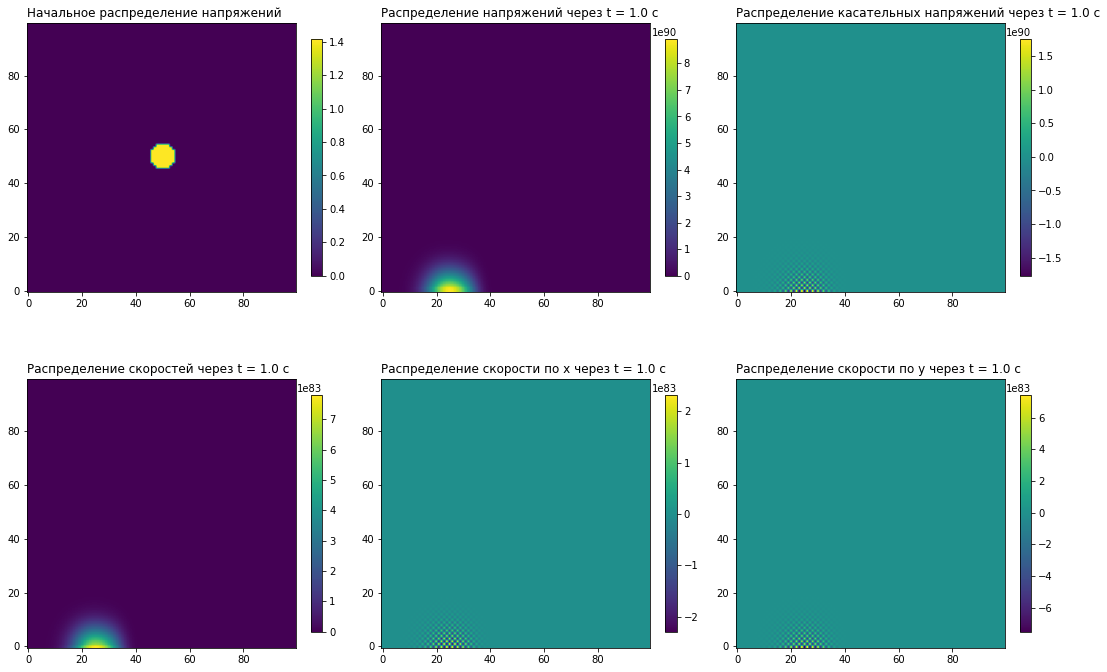

In [71]:
fig, ax = plt.subplots(2, 3, figsize=(18,12))
ax[0][0].set_title('Начальное распределение напряжений', loc="left")
img = ax[0][0].imshow(np.sqrt(data_start['sxx'] ** 2 + data_start['syy'] ** 2), origin = 'lower')
plt.colorbar(img, ax=ax[0][0], fraction=0.04, shrink=0.9)

ax[0][1].set_title('Распределение напряжений через t = ' + str(round(T / 1, 2)) + ' с', loc="left")
img = ax[0][1].imshow(np.sqrt(data_current['sxx'] ** 2 + data_current['syy'] ** 2), origin = 'lower')
plt.colorbar(img, ax=ax[0][1], fraction=0.04, shrink=0.9)

ax[0][2].set_title('Распределение касательных напряжений через t = ' + str(round(T / 1, 2)) + ' с', loc="left")
img = ax[0][2].imshow(data_current['sxy'], origin = 'lower')
plt.colorbar(img, ax=ax[0][2], fraction=0.04, shrink=0.9)

ax[1][0].set_title('Распределение скоростей через t = ' + str(round(T / 1, 2)) + ' с', loc="left")
img = ax[1][0].imshow(np.sqrt(data_current['vx'] ** 2 + data_current['vy'] ** 2), origin = 'lower')
plt.colorbar(img, ax=ax[1][0], fraction=0.04, shrink=0.9)

ax[1][1].set_title('Распределение скорости по x через t = ' + str(round(T / 1, 2)) + ' с', loc="left")
img = ax[1][1].imshow(data_current['vx'], origin = 'lower')
plt.colorbar(img, ax=ax[1][1], fraction=0.04, shrink=0.9)

ax[1][2].set_title('Распределение скорости по y через t = ' + str(round(T / 1, 2)) + ' с', loc="left")
img = ax[1][2].imshow(data_current['vy'], origin = 'lower')
plt.colorbar(img, ax=ax[1][2], fraction=0.04, shrink=0.9)
